In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.autograd import Variable

[1.48671951e-06 1.56294518e-06 1.64291438e-06 1.72680223e-06
 1.81479157e-06 1.90707332e-06 2.00384677e-06 2.10531999e-06
 2.21171010e-06 2.32324372e-06 2.44015731e-06 2.56269761e-06
 2.69112199e-06 2.82569895e-06 2.96670852e-06 3.11444274e-06
 3.26920615e-06 3.43131624e-06 3.60110404e-06 3.77891458e-06
 3.96510749e-06 4.16005756e-06 4.36415530e-06 4.57780761e-06
 4.80143840e-06 5.03548920e-06 5.28041992e-06 5.53670947e-06
 5.80485658e-06 6.08538047e-06 6.37882168e-06 6.68574289e-06
 7.00672970e-06 7.34239154e-06 7.69336257e-06 8.06030255e-06
 8.44389784e-06 8.84486240e-06 9.26393876e-06 9.70189908e-06
 1.01595463e-05 1.06377152e-05 1.11372736e-05 1.16591234e-05
 1.22042022e-05 1.27734842e-05 1.33679815e-05 1.39887459e-05
 1.46368699e-05 1.53134881e-05 1.60197791e-05 1.67569666e-05
 1.75263212e-05 1.83291622e-05 1.91668589e-05 2.00408326e-05
 2.09525584e-05 2.19035668e-05 2.28954459e-05 2.39298433e-05
 2.50084680e-05 2.61330924e-05 2.73055547e-05 2.85277610e-05
 2.98016873e-05 3.112938

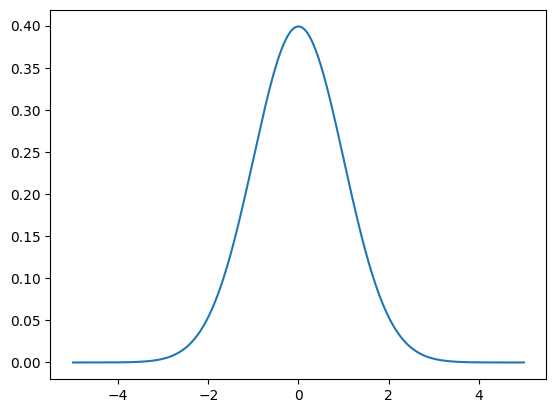

In [ ]:
mu,sigma = 0,1
num_samples = 1000
xs = np.linspace(-5, 5, num_samples) # interval = 10/1000=0.01
samples = norm.pdf(xs, mu, sigma)
print(samples)
plt.plot(xs, samples)

In [ ]:
# Real data distribution
class RealDistribution:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def sample(self, num_samples):
        samples = np.random.normal(self.mu, self.sigma, num_samples)
        samples.sort()

        return samples

# Noise data distribution as inputs for the generator
class NoiseDistribution:
    def __init__(self, data_range):
        self.data_range = data_range

    def sample(self, num_samples):
        offset = np.random.random(num_samples)*0.01 # Random floats with uniform dist. in the interval [0.0, 0.01)
        samples = np.linspace(-self.data_range, self.data_range, num_samples)

        return samples

In [ ]:
def linear(input_dim, output_dim):
    fc = nn.Linear(input_dim, output_dim, bias=True)
    # initializer
    nn.init.normal_(fc.weight, std=1.0)
    nn.init.constant_(fc.bias, 0.0)

    return nn.Sequential(fc, nn.ReLU())


class Generator(nn.Module):     # 1->32->1
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        # Hidden layer
        self.hidden_layer = linear(input_dim, hidden_dim)
        fc = nn.Linear(hidden_dim, output_dim, bias=True)
        # initializer
        nn.init.normal_(fc.weight, std=1.0)
        nn.init.constant_(fc.bias, 0.0)
        # Output layer
        #self.output_layer = nn.Sequential(fc, nn.Tanh())
        self.output_layer = nn.Sequential(fc)

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)

        return out

In [ ]:
def minibatch(input, num_kernels=8, kernel_dim=3):
    x = nn.Linear(input.size()[1], num_kernels * kernel_dim, bias=True)(input)
    activation = x.view(-1, num_kernels, kernel_dim)
    diffs = activation.unsqueeze(3) - activation.permute(1, 2, 0).unsqueeze(0)
    abs_diffs = torch.sum(torch.abs(diffs), dim=2)
    minibatch_features = torch.sum(torch.exp(-abs_diffs), dim=2)

    return torch.cat((input, minibatch_features), 1)

class Discriminator(nn.Module): # 1->32->1
    def __init__(self, input_dim, hidden_dim, output_dim, minibatch=False):
        super(Discriminator, self).__init__()

        self.minib = minibatch
        if not self.minib:
            self.hidden_layer = linear(input_dim, hidden_dim)
        else:
            self.hidden_layer = linear(input_dim, int(3*hidden_dim/4))

        # Output layer
        fc = nn.Linear(hidden_dim, output_dim, bias=True)
        nn.init.normal_(fc.weight, std=1.0)
        nn.init.constant_(fc.bias, 0.0)
        self.output_layer = nn.Sequential(fc, nn.Sigmoid())

    def forward(self, x):
        h = self.hidden_layer(x)

        if self.minib:
            h = minibatch(h, num_kernels=8, kernel_dim=3)

        out = self.output_layer(h)

        return out

In [ ]:
# Test samples
class TestSample:
    def __init__(self, discriminator, generator, realD, data_range, batch_size, num_samples, num_bins):
        self.D = discriminator
        self.G = generator
        self.realD = realD
        self.bs = batch_size
        self.num_samples = num_samples
        self.num_bins = num_bins
        self.xs = np.linspace(-data_range, data_range, num_samples)
        self.bins = np.linspace(-data_range, data_range, num_bins)

    def decision_boundary(self):
        db = np.zeros((self.num_samples, 1))
        for i in range(self.num_samples // self.bs):
            x_ = self.xs[self.bs*i:self.bs*(i+1)]
            x_ = Variable(torch.FloatTensor(np.reshape(x_, [self.bs, 1])))

            db[self.bs*i:self.bs*(i+1)] = self.D(x_).detach().numpy()

        return db

    def real_distribution(self):
        d = self.realD.sample(self.num_samples)
        p_data, _ = np.histogram(d, self.bins, density=True)

        return p_data

    def gen_distribution(self):
        zs = self.xs
        g = np.zeros((self.num_samples, 1))
        for i in range(self.num_samples // self.bs):
            z_ = zs[self.bs*i:self.bs*(i+1)]
            z_ = Variable(torch.FloatTensor(np.reshape(z_, [self.bs, 1])))
            g[self.bs*i:self.bs*(i+1)] = self.G(z_).detach().numpy()

        p_gen, _ = np.histogram(g, self.bins, density=True)

        return p_gen

In [ ]:
class Display:
    def __init__(self, num_samples, num_bins, data_range, mu, sigma):
        self.num_samples = num_samples
        self.num_bins = num_bins
        self.data_range = data_range
        self.mu = mu
        self.sigma = sigma

    def plot_result(self, db_pre_trained, db_trained, p_data, p_gen):
        d_x = np.linspace(-self.data_range, self.data_range, len(db_trained))
        p_x = np.linspace(-self.data_range, self.data_range, len(p_data))

        f, ax = plt.subplots(1)
        ax.plot(d_x, db_pre_trained, '--', label='Decision boundary (pre-trained)')
        ax.plot(d_x, db_trained, label='Decision boundary')
        ax.set_ylim(0, max(1, np.max(p_data)*2.0))
        ax.set_xlim(self.mu-self.data_range*1.0, self.mu+self.data_range*1.0)
        plt.plot(p_x, p_data, label='Real data')
        plt.plot(p_x, p_gen, label='Generated data')
        plt.title('Gaussian Approximation using GAN: ' + '(mu: %3g,' % self.mu + ' sigma: %3g)' % self.sigma)
        plt.xlabel('Data values')
        plt.ylabel('Probability density')
        plt.legend(loc=1)
        plt.grid(True)

        # Save plot
        #save_dir = "result/"
        #if not os.path.exists(save_dir):
        #    os.mkdir(save_dir)
        #plt.savefig(save_dir + '1D_Gaussian' + '_mu_%g' % self.mu + '_sigma_%g' % self.sigma + '.png')

        plt.show()

In [ ]:
# Hyper-parameters
mu = 0.0
sigma = 1.0
data_range = 5
batch_size = 10

input_dim = 1
hidden_dim = 32
output_dim = 1
num_epochs = 2000
num_epochs_pre = 2000
learning_rate = 0.001

In [ ]:
# Samples
realData = RealDistribution(mu, sigma)     # via np.random.normal
noiseData = NoiseDistribution(data_range)  # unfiorm plus some variations

# Create models
G = Generator(input_dim, hidden_dim, output_dim)
D = Discriminator(input_dim, hidden_dim, output_dim, True)
#D = Discriminator(input_dim, hidden_dim, output_dim)

# Save intialized models
#torch.save(G.state_dict(), './SavedModel/Gini.pt')
#torch.save(D.state_dict(), './SavedModel/Dini.pt')
#G.load_state_dict(torch.load('./SavedModel/Gini.pt'))
#G.train()
#D.load_state_dict(torch.load('./SavedModel/Dini.pt'))
#D.train()

# Loss function (MSE loss)
#pre_criterion = nn.MSELoss()
pre_criterion = nn.BCELoss()

# optimizer
optimizer = torch.optim.SGD(D.parameters(), lr=learning_rate)

# Print model's state_dict
print("Generator's state_dict:")
for param_tensor in G.state_dict():
    print(param_tensor, "\t", G.state_dict()[param_tensor].size())

print("Discriminator's state_dict:")
for param_tensor in D.state_dict():
    print(param_tensor, "\t", D.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Generator's state_dict:
hidden_layer.0.weight 	 torch.Size([32, 1])
hidden_layer.0.bias 	 torch.Size([32])
output_layer.0.weight 	 torch.Size([1, 32])
output_layer.0.bias 	 torch.Size([1])
Discriminator's state_dict:
hidden_layer.0.weight 	 torch.Size([24, 1])
hidden_layer.0.bias 	 torch.Size([24])
output_layer.0.weight 	 torch.Size([1, 32])
output_layer.0.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3]}]


In [ ]:
num_samples_pre = 10000
num_bins_pre = 100 # number of equal-width bins in a histogram
D_pre_losses = []
real = realData.sample(1000000)
print(real)
histc, edges = np.histogram(real, num_bins_pre, density=True)
print(histc)
max_histc = np.max(histc)
min_histc = np.min(histc)
y_ = (histc - min_histc) / (max_histc - min_histc)
y_ = Variable(torch.FloatTensor(np.reshape(y_, [num_bins_pre, output_dim])))
print(f"y_ ={y_}")
#display.plot_result(y_, y_, y_, 0)

[-4.75369529 -4.63884275 -4.63031716 ...  4.63664212  4.6400321
  4.83522311]
[1.04287049e-05 3.12861146e-05 1.04287049e-05 3.12861146e-05
 5.21435244e-05 6.25722292e-05 1.25144458e-04 1.56430573e-04
 2.08574097e-04 2.81575032e-04 4.48434310e-04 4.58863014e-04
 5.94436178e-04 1.02201308e-03 1.32444552e-03 1.79373724e-03
 2.64889104e-03 3.29547074e-03 4.70334590e-03 6.05907753e-03
 8.08224628e-03 1.07728521e-02 1.44228988e-02 1.70509325e-02
 2.18585654e-02 2.61969066e-02 3.40914362e-02 4.21945399e-02
 5.10380816e-02 6.32813812e-02 7.50449603e-02 8.89255664e-02
 1.04422622e-01 1.21150265e-01 1.39431784e-01 1.60800200e-01
 1.82179045e-01 2.03297173e-01 2.27877630e-01 2.50142915e-01
 2.71824192e-01 2.96748797e-01 3.19160084e-01 3.37222601e-01
 3.54711539e-01 3.69447299e-01 3.77665118e-01 3.91524867e-01
 3.99784401e-01 4.00118120e-01 3.98303525e-01 3.91212006e-01
 3.87238669e-01 3.73024345e-01 3.54638538e-01 3.38901622e-01
 3.18033784e-01 2.99783550e-01 2.76996830e-01 2.50904211e-01
 2.2833

Streaming output truncated to the last 5000 lines.
[-5.57683354 -5.06527273 -4.83670331 ...  4.61248705  4.63254481
  4.66294016]
[-4.78638934 -4.61200636 -4.59274054 ...  4.45018028  4.47940394
  4.53866018]
[-4.7225293  -4.65415506 -4.54667125 ...  4.54489329  4.54595476
  5.33245443]
[-5.13731747 -4.49888061 -4.4796742  ...  4.63864235  4.92751802
  4.99864476]
[-5.05380783 -4.64026644 -4.48842435 ...  4.54573958  4.83968696
  5.33320026]
[-5.62872017 -4.68959246 -4.60583862 ...  4.59043605  4.79131681
  4.82147998]
[-4.52752434 -4.52424619 -4.50477878 ...  4.60045219  4.62070538
  4.85311497]
[-4.7541265  -4.728878   -4.63409857 ...  4.52736033  4.55966386
  4.81658404]
[-4.5845101  -4.50065579 -4.45135469 ...  4.40041981  4.4220093
  5.14950085]
[-5.40531222 -4.76548869 -4.59155127 ...  4.43040058  4.45386851
  4.56315625]
[-4.91721827 -4.74371948 -4.60241329 ...  4.81046987  5.00041659
  5.05724001]
[-5.02335909 -4.61796118 -4.6065399  ...  4.48390255  4.6002715
  4.6888149 ]
[-4

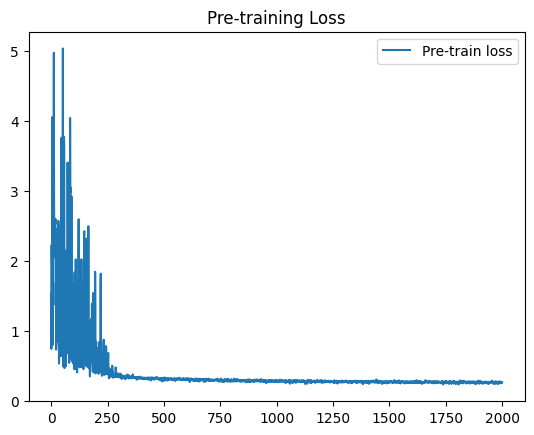

In [ ]:
num_samples_pre = 1000000
num_bins_pre = 100 # number of equal-width bins in a histogram
D_pre_losses = []
for epoch in range(num_epochs_pre):
    # Generate samples
    real = realData.sample(num_samples_pre)
    print(real)
    histc, edges = np.histogram(real, num_bins_pre, density=True)
    #print(histc)
    #plt.plot(histc)
    #plt.show()
    # Estimate pdf
    max_histc = np.max(histc)
    min_histc = np.min(histc)
    y_ = (histc - min_histc) / (max_histc - min_histc)  # normalize y_ to range [0,1]
    #print('len of y_: ', len(y_), ', y_: ', y_)
    x_ = edges[1:]

    x_ = Variable(torch.FloatTensor(np.reshape(x_, [num_bins_pre, input_dim])))
    y_ = Variable(torch.FloatTensor(np.reshape(y_, [num_bins_pre, output_dim])))
    #print(y_)

    # Train D model
    optimizer.zero_grad()
    D_pre_decision = D(x_)
    D_pre_loss = pre_criterion(D_pre_decision, y_)
    #D_pre_loss = torch.mean(-torch.log(D_pre_decision)-torch.log(1.-y_))
    D_pre_loss.backward()
    optimizer.step()

    # Save loss values for plot
    D_pre_losses.append(D_pre_loss.item())

    if epoch % 100 == 0:
        print(D_pre_decision)
        print(epoch, D_pre_loss.item())
        #display = Display(num_samples_pre, num_bins_pre, data_range, mu, sigma)
        #display.plot_result(y_, y_, y_, epoch)
    #print(epoch, D_pre_loss.item())

# Plot loss
fig, ax = plt.subplots()
losses = np.array(D_pre_losses)
plt.plot(losses, label='Pre-train loss')
plt.title("Pre-training Loss")
plt.legend()
plt.show()

In [ ]:
# Test sample after pre-training (to be drawn later)
num_samples = 1000000
num_bins = 100
sample = TestSample(D, G, realData, data_range, batch_size, num_samples, num_bins)
db_pre_trained = sample.decision_boundary()

In [ ]:
def training_loop(D,G):
  # Optimizers
  D_optimizer = torch.optim.SGD(D.parameters(), lr=learning_rate)
  G_optimizer = torch.optim.SGD(G.parameters(), lr=learning_rate)

  D_losses = []
  G_losses = []
  for epoch in range(num_epochs):
      # Generate samples
      x_ = realData.sample(batch_size)
      x_ = Variable(torch.FloatTensor(np.reshape(x_, [batch_size, input_dim])))
      y_real_ = Variable(torch.ones([batch_size, output_dim]))
      y_fake_ = Variable(torch.zeros([batch_size, output_dim]))

      # Train discriminator with real data
      D_real_decision = D(x_)
      #D_real_loss = criterion(D_real_decision, y_real_)

      # Train discriminator with fake data
      z_ = noiseData.sample(batch_size)
      z_ = Variable(torch.FloatTensor(np.reshape(z_, [batch_size, input_dim])))
      z_ = G(z_)
      #print(f"generator output = {z_}")
      #print(f"Generator output lies between {np.max(z_)},{np.min(z_)}")
      D_fake_decision = D(z_)
      #D_fake_loss = criterion(D_fake_decision, y_fake_)

      # Back propagation
      #D_loss = D_real_loss + D_fake_loss
      D_loss = torch.mean(-torch.log(D_real_decision)-torch.log(1.-D_fake_decision))
      D.zero_grad()
      D_loss.backward()
      D_optimizer.step()

      # Train generator
      z_ = noiseData.sample(batch_size)
      z_ = Variable(torch.FloatTensor(np.reshape(z_, [batch_size, input_dim])))
      z_ = G(z_)

      D_fake_decision = D(z_)
      #G_loss = criterion(D_fake_decision, y_real_) # note that we put y_real_ here
      G_loss = torch.mean(-torch.log(D_fake_decision))

      # Back propagation
      D.zero_grad()
      G.zero_grad()
      G_loss.backward()
      G_optimizer.step()

      # Save loss values for plot
      D_losses.append(D_loss.item())
      G_losses.append(G_loss.item())
      #plot_losses(D_losses,G_losses)
      print('epoch:{}, D loss:{}, G loss:{}'.format(epoch, D_loss.item(), G_loss.item()))

      if epoch % 1000 == 0:
          plot_losses(D_losses,G_losses)
          test_sample(D, G, realData, data_range, batch_size, num_samples, num_bins)

In [ ]:
# Plot losses
def plot_losses(D_losses,G_losses):
  fig, ax = plt.subplots()
  D_losses = np.array(D_losses)
  G_losses = np.array(G_losses)
  plt.plot(D_losses, label='Discriminator')
  plt.plot(G_losses, label='Generator')
  plt.title("Training Losses")
  plt.legend()
  plt.show()

In [ ]:
# Test sample after GAN-training
def test_sample(D, G, realData, data_range, batch_size, num_samples, num_bins):
  sample = TestSample(D, G, realData, data_range, batch_size, num_samples, num_bins)
  db_trained = sample.decision_boundary()
  p_data = sample.real_distribution()
  p_gen = sample.gen_distribution()

  # Display result
  display = Display(num_samples, num_bins, data_range, mu, sigma)
  display.plot_result(db_pre_trained, db_trained, p_data, p_gen)

In [ ]:
cycles=11
for i in range(cycles):
  training_loop(D,G)